# Exercícios

1. Plotar algumas imagens do dataset fashion MNIST para ter uma idea de como são as amostras.
1. Estimar os rótulos das amostras de teste, computar a acurácia e gerar uma matriz de confusão para ver com quais classes cada classe está se confundindo.
1. Rodar esse algoritmo utilizando o dataset Kuzushiji-MNIST (KMNIST). Pesquisar para fazer aumento de dados (transform) com horizontal flipping. Plotar algumas imagens desse dataset também.

---

## Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [2]:
from logisticregression import *

In [3]:
#  Verificando a versão do PyTorch e se está usando GPU
print('Versão PyTorch: ', torch.__version__)
print('Usando GPU: ', torch.cuda.is_available())

if torch.cuda.is_available():    
    print('GPU: ',torch.cuda.get_device_name(torch.cuda.current_device()))

Versão PyTorch:  1.8.1
Usando GPU:  False


---

# Fashion MNIST

## 1. Download dos dados

In [4]:
train_dataset = dsets.FashionMNIST(root='~/data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.FashionMNIST(root='~/data', train=False, transform=transforms.ToTensor())

In [5]:
print(f"> {len(train_dataset)} amostras de Treino e {len(test_dataset)} amostras de Teste")

> 60000 amostras de Treino e 10000 amostras de Teste


## 2. Plotando algumas imagens

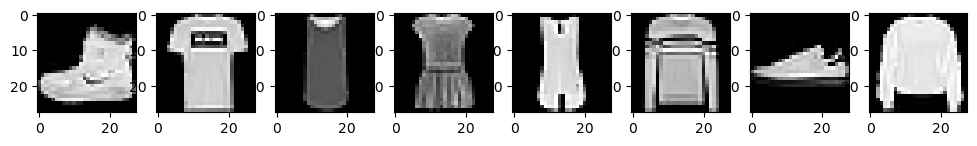

In [6]:
num_imagens = 8

fig, axs = plt.subplots(1, num_imagens, figsize=(12,4))
for i in range(num_imagens):
    axs[i].imshow(train_dataset[i][0].reshape(28,28), cmap=plt.get_cmap("gray"))

plt.show()

## 3. Criando o modelo

### 3a. Data loader

In [7]:
batch_size = 200

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### 3b. Definindo hyperparâmetros e instanciando o modelo

In [8]:
n_iters = 5000
epochs = n_iters/(len(train_dataset)/batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01

In [9]:
model = LogisticRegression(input_dim, output_dim)

### 3c. Instanciando a classe Loss

In [10]:
criterion = torch.nn.CrossEntropyLoss()

### 3d. Definindo otimizador

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

## 4. Treinando o modelo

In [12]:
iter = 0
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct.float()/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.8419749736785889. Accuracy: 72.37000274658203.
Iteration: 1000. Loss: 0.6340858340263367. Accuracy: 76.0999984741211.
Iteration: 1500. Loss: 0.594872772693634. Accuracy: 77.97000122070312.
Iteration: 2000. Loss: 0.6388338208198547. Accuracy: 78.87000274658203.
Iteration: 2500. Loss: 0.5685663819313049. Accuracy: 79.6500015258789.
Iteration: 3000. Loss: 0.5081735849380493. Accuracy: 80.4000015258789.
Iteration: 3500. Loss: 0.5422673225402832. Accuracy: 80.41999816894531.
Iteration: 4000. Loss: 0.4957231879234314. Accuracy: 80.87999725341797.
Iteration: 4500. Loss: 0.5105141997337341. Accuracy: 80.98999786376953.


## 5. Estimando os rótulos das amostras de teste

In [13]:
predicted = []
expected = []

for image, label in test_dataset:
    image = Variable(image.view(-1, 28*28))
    outputs = model(image)
    _, prediction = torch.max(outputs.data, 1)
    predicted.append(prediction.item())
    expected.append(label)

In [14]:
results = pd.DataFrame({'predicted': predicted, 'expected':expected})
results

,predicted,expected
0,9,9
1,2,2
2,1,1
3,1,1
4,6,6
...,...,...
9995,9,9
9996,1,1
9997,8,8
9998,1,1


## 6. Avaliando o modelo

### 6a. Acurácia

In [15]:
accuracy = (results['predicted'] == results['expected']).sum()/len(results)
print(f"Acurácia do modelo: {accuracy}")

Acurácia do modelo: 0.814


### 6b. Matriz de confusão

In [16]:
label_dict = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
              5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

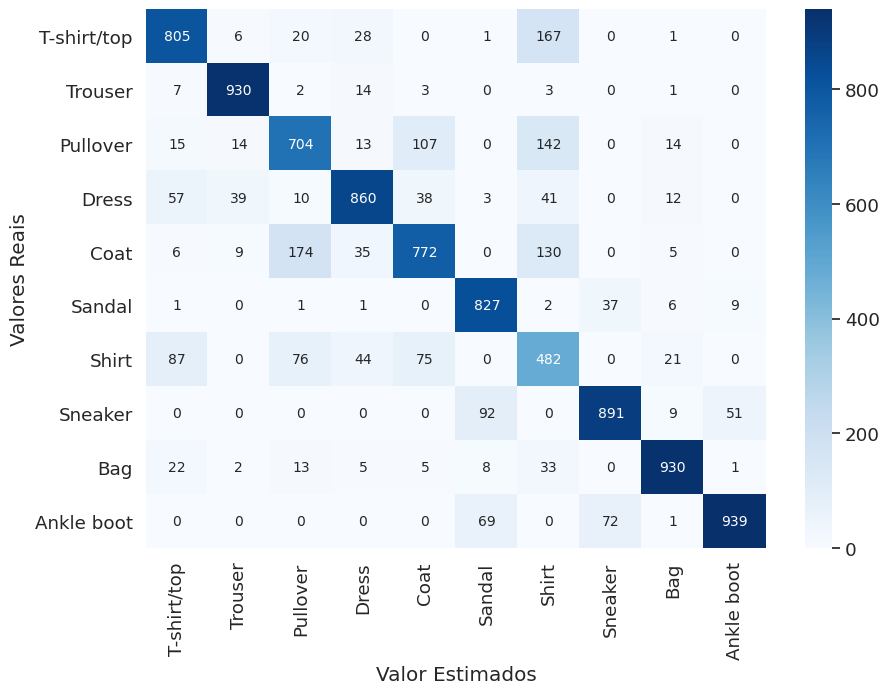

In [17]:
cm = confusion_matrix(predicted, expected)
df_cm = pd.DataFrame(cm, columns=label_dict.values(), index=label_dict.values())
df_cm.index.name = "Valores Reais"
df_cm.columns.name = "Valor Estimados"
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
plt.show()

---

# Kuzushiji-MNIST

## 1. Download dos dados

In [18]:
train_dataset = dsets.KMNIST(root='~/data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.KMNIST(root='~/data', train=False, transform=transforms.ToTensor())

In [19]:
print(f"> {len(train_dataset)} amostras de Treino e {len(test_dataset)} amostras de Teste")

> 60000 amostras de Treino e 10000 amostras de Teste


## 2. Plotando algumas imagens

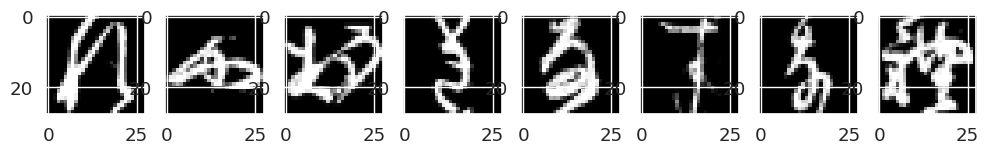

In [20]:
num_imagens = 8

fig, axs = plt.subplots(1, num_imagens, figsize=(12,4))
for i in range(num_imagens):
    axs[i].imshow(train_dataset[i][0].reshape(28,28), cmap=plt.get_cmap("gray"))

plt.show()

## 3. Criando o modelo

### 3a. Data loader

In [21]:
batch_size = 200

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### 3b. Definindo hyperparâmetros e instanciando o modelo

In [22]:
n_iters = 5000
epochs = n_iters/(len(train_dataset)/batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01

In [23]:
model = LogisticRegression(input_dim, output_dim)

### 3c. Instanciando a classe Loss

In [24]:
criterion = torch.nn.CrossEntropyLoss()

### 3d. Definindo otimizador

In [25]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

## 4. Treinando o modelo

In [26]:
iter = 0
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct.float()/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.9912810325622559. Accuracy: 56.279998779296875.
Iteration: 1000. Loss: 0.9333953261375427. Accuracy: 60.630001068115234.
Iteration: 1500. Loss: 0.8514499664306641. Accuracy: 62.790000915527344.
Iteration: 2000. Loss: 0.7468425631523132. Accuracy: 63.91999816894531.
Iteration: 2500. Loss: 0.72348952293396. Accuracy: 64.81999969482422.
Iteration: 3000. Loss: 0.7304612994194031. Accuracy: 65.37999725341797.
Iteration: 3500. Loss: 0.6710055470466614. Accuracy: 65.62999725341797.
Iteration: 4000. Loss: 0.609311044216156. Accuracy: 65.98999786376953.
Iteration: 4500. Loss: 0.7585399150848389. Accuracy: 66.36000061035156.


## 5. Estimando os rótulos das amostras de teste

In [27]:
predicted = []
expected = []

for image, label in test_dataset:
    image = Variable(image.view(-1, 28*28))
    outputs = model(image)
    _, prediction = torch.max(outputs.data, 1)
    predicted.append(prediction.item())
    expected.append(label)

In [28]:
results = pd.DataFrame({'predicted': predicted, 'expected':expected})
results

,predicted,expected
0,5,2
1,9,9
2,3,3
3,8,8
4,3,3
...,...,...
9995,9,4
9996,0,0
9997,9,9
9998,0,4


## 6. Avaliando o modelo

### 6a. Acurácia

In [29]:
accuracy = (results['predicted'] == results['expected']).sum()/len(results)
print(f"Acurácia do modelo: {accuracy}")

Acurácia do modelo: 0.6668


### 6b. Matriz de confusão

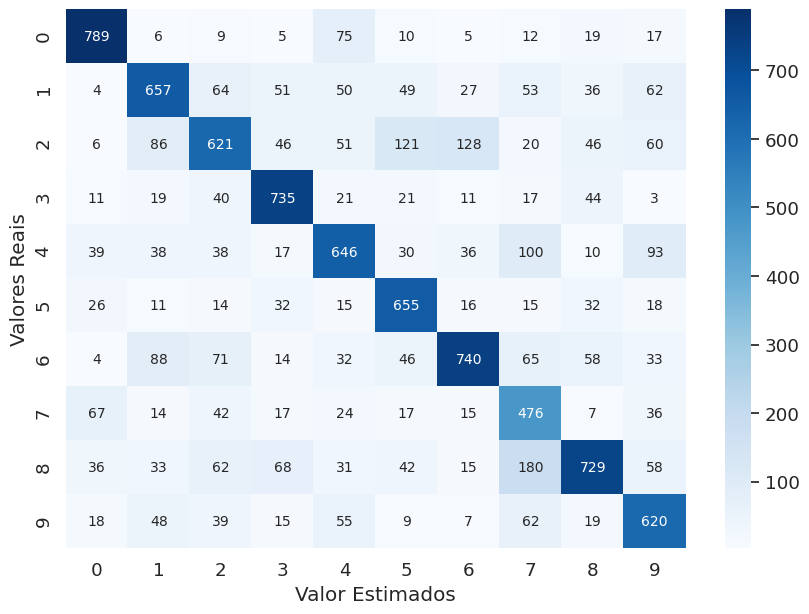

In [30]:
cm = confusion_matrix(predicted, expected)
df_cm = pd.DataFrame(cm)
df_cm.index.name = "Valores Reais"
df_cm.columns.name = "Valor Estimados"
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
plt.show()

---

# Aplicando 'horizontal flipping' no Kuzushiji-MNIST

## 1. Download aplicando o 'horizontal flipping'

In [53]:
# Horizontal Flipping com probabilidade 0.5
horiz_flipp = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                             transforms.ToTensor()])

train_transf_dataset = dsets.KMNIST(root='~/data', train=True, transform=horiz_flipp)
test_transf_dataset = dsets.KMNIST(root='~/data', train=False, transform=horiz_flipp)

## 2. Comparando as imagens

* Imagens originais

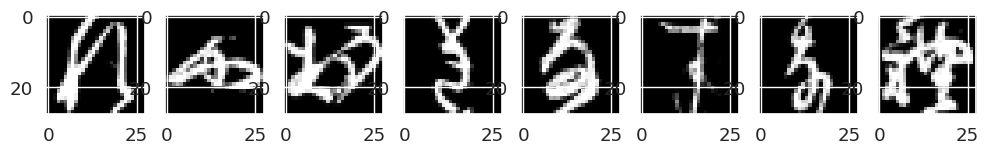

In [54]:
num_imagens = 8

fig, axs = plt.subplots(1, num_imagens, figsize=(12,4))
for i in range(num_imagens):
    axs[i].imshow(train_dataset[i][0].reshape(28,28), cmap=plt.get_cmap("gray"))

plt.show()

* Aplicando o 'horizontal flipping'

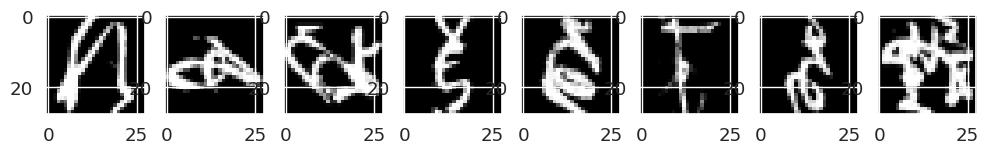

In [55]:
num_imagens = 8

fig, axs = plt.subplots(1, num_imagens, figsize=(12, 4))
for i in range(num_imagens):
    axs[i].imshow(train_transf_dataset[i][0].reshape(28, 28), cmap=plt.get_cmap("gray"))
    
plt.show()

## 3. Criando o modelo

### 3a. Data loader

In [56]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_transf_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_transf_dataset, batch_size=batch_size, shuffle=False)

### 3b. Definindo hyperparâmetros e instanciando o modelo

In [57]:
n_iters = 5000
epochs = n_iters/(len(train_dataset)/batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01

In [58]:
model = LogisticRegression(input_dim, output_dim)

### 3c. Instanciando a classe Loss

In [59]:
criterion = torch.nn.CrossEntropyLoss()

### 3d. Definindo otimizador

In [60]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

## 4. Treinando o modelo

In [61]:
iter = 0
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels b200ack to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct.float()/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.4216340780258179. Accuracy: 48.97999954223633.
Iteration: 1000. Loss: 1.2183908224105835. Accuracy: 51.119998931884766.
Iteration: 1500. Loss: 1.0199172496795654. Accuracy: 52.040000915527344.
Iteration: 2000. Loss: 1.0815091133117676. Accuracy: 52.4900016784668.
Iteration: 2500. Loss: 1.0154372453689575. Accuracy: 52.86000061035156.
Iteration: 3000. Loss: 1.09457528591156. Accuracy: 53.43000030517578.
Iteration: 3500. Loss: 1.0233407020568848. Accuracy: 53.65999984741211.
Iteration: 4000. Loss: 0.9652765393257141. Accuracy: 53.970001220703125.
Iteration: 4500. Loss: 0.9181030988693237. Accuracy: 54.08000183105469.


## 5. Estimando os rótulos das amostras de teste

In [62]:
predicted = []
expected = []

for image, label in test_dataset:
    image = Variable(image.view(-1, 28*28))
    outputs = model(image)
    _, prediction = torch.max(outputs.data, 1)
    predicted.append(prediction.item())
    expected.append(label)

In [63]:
results = pd.DataFrame({'predicted': predicted, 'expected':expected})
results

,predicted,expected
0,5,2
1,9,9
2,3,3
3,8,8
4,3,3
...,...,...
9995,0,4
9996,5,0
9997,2,9
9998,9,4


## 6. Avaliando o modelo

### 6a. Acurácia

In [64]:
accuracy = (results['predicted'] == results['expected']).sum()/len(results)
print(f"Acurácia do modelo: {accuracy}")

Acurácia do modelo: 0.5408


### 6b. Matriz de confusão

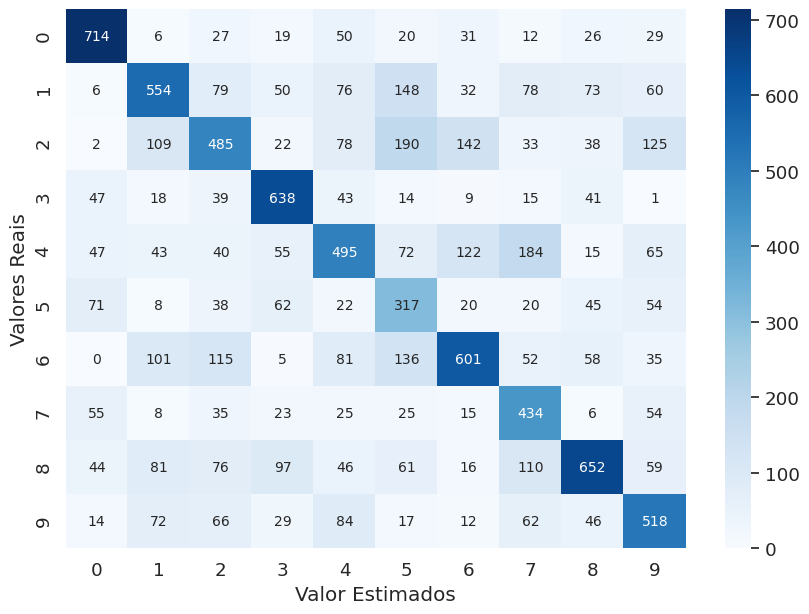

In [65]:
cm = confusion_matrix(predicted, expected)
df_cm = pd.DataFrame(cm)
df_cm.index.name = "Valores Reais"
df_cm.columns.name = "Valor Estimados"
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
plt.show()